In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2015-11-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'time_series_2017_2020'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/agg_results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# map water name slug to type
wname_type = dfBeaches[["water_name_slug", "water"]].reset_index(drop=True).drop_duplicates()
water_type_map = wname_type.set_index('water_name_slug', drop=True)

def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y='pcs_m', ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr = stats.spearmanr(data[n], data['pcs_m']).correlation
    a_p = stats.spearmanr(data[n], data['pcs_m']).pvalue
    return ax, corr, a_p

dfCodes.set_index("code", inplace=True)
# these descriptions need to be shortened for display
# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

<a id='top'></a>
## Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQAASL)

IQAASL is a project sponsored by the Swiss Federal Office for the Environment to quantify shoreline trash along swiss lakes and rivers. Multiple small scale **litter surveys** are completed at different locations within a designated survey area. For the year 2020/2021 the survey areas were defined by the municipalities that border the Aare, Rhône, Ticino and Linth/Limmat rivers and any lakes or rivers that contribute to one of these rivers.

#### Purpose of this report

Compare the survey results from the lakes and rivers that have common survey locations in the Swiss Litter Report<sup>8</sup> and IQAASL.

[Conclusions](#conc) &ensp; [Table of contents](#toc)

### What is a litter survey?

A litter survey is the **identification and count of all anthropogenic objects found within a delimited area**, in this study all surveys were bordered on one side by water (a river or lake). Each object is placed into one of 260 categories<sup>9</sup>. The location, date, survey dimensions and the total number of objects in each category is noted. 

#### Purpose of the surveys

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment and where those objects are most likely to be found. The surveys answer the following questions:

*  What items are found?
   * The most common objects indentified from the water feature or survey area
*  How much is found ? 
   * Pieces of trash per 100 meters (p/100m): the ratio of number of objects found to the length of the shoreline for each survey location
*  How often are these items found?
   * How often the most abundant items were identified
*  Where do you find the most?
   * Correlation of survey results to land use attributes   

These are the most frequently asked questions and should be considered when determining any mitigation or reduction strategies.

#### Assumptions:

*  The more trash there is on the ground the more a person is likely to find
*  The survey results represent the minimum amount of trash at that site<sup>10</sup>
*  For each survey: finding one item does not effect the chance of finding another<sup>11</sup>

### Summary

In this report the survey results are compared in two parts. First an overview of the survey results for all lakes and rivers that were surveyed in both projects. Then a detailed analysis of the six lakes that were sampled in both projects.

#### [The projects](#scope)

Between April 2017 and March 2018 1,052 samples were taken from 112 locations in the Swiss Litter Report<sup>8</sup>. IQAASL ran through Jan 2020 to May 2021 collecting 386 samples from 143 locations in 77 different municipalities.

#### [Lakes and rivers](#summarydata)

Consider first only the lakes and rivers that have samples in both years. There were more samples and more trash was collected from fewer locations in 2017 than 2020. However, on a pieces per meter basis the mean, median and maximum were all higher in 2020. The difference is slight and in real terms is less than 30 pieces of trash per 100m, differences of this magnitude may not be immediately discernible to the casual observer<sup>12</sup>.

Both projects follwed the *Guide on monitoring marine litter*<sup>9</sup>. However, the 2017 project limited the object counts to items greater than 2.5cm. The 2020 protocol allowed for a wider range of visible material to be collected, weighed and categorized including all plastic and foam pieces between 0.5cm to 2.5cm. In 2017 no data was collected for items less than 2.5cm and this is a limiting factor when comparing the results of expanded foams and fragmented plastics from one project to another.

#### [Focus on lakes](#scope)

Lakes provide consistent survey conditions throughout the year.

The following lakes were sampled in both project years:

1. Zurichsee
2. Bielersee
3. Neuenburgersee
4. Walensee
5. Lac Léman
6. Thunersee

There were 70 different survey locations in 2020 versus 22 in 2017, 16/22 locations were resampled in 2020 and four locations did not meet the sampling criteria. Of the 282 samples in 2020 100 were from locations that had been sampled in 2017.

#### [Accounting for land use](#luseprofile)

Land use attributes are measurable properties that are geolocated and can be extracted from the current versions of Statistique suisse de la superficie<sup>17</sup> and swissTlmRegio<sup>18</sup>. For more information on how the land use attributes are calculated see 'land use correlation'<sup>19</sup>

The land use profile within 1500 meters around each survey location was evaluated for the following criteria:

1. % of surface area attributed to buildings
2. % of surface area left to woods
3. % of surface area attributed to outdoor activities
4. % of surface area attributed to aggriculture
5. length in meters of all roadways
6. number of river discharge intersections

For both projects 50% of the samples had less than ~36% of land attributed to buildings, less than ~5% attributed to recreation and less than ~10% attributed to woods or forest. In 2017 50% of the samples had less than ~25% of land attributed to agriculture versus ~14% for 2020. The smallest population was 442 and the largest was 415,357. At least 50% of the samples came from municipalities with a population of ~13000 or less. The survey areas in 2020 were slightly more urban than 2017.

#### [Survey results: lakes](#thelakessum)

When just the six lakes are considered there were more samples, more locations and more trash was collected in 2020, but the median 184p/100m and average 339p/100m were both lower with respect to 2017, 533p/100m and 339p/100m. Under similar sampling conditions the distribution of the survey results diverge, only ~5% of the surveys had less than 50p/100m in 2017 that number increased ~13% in 2020. 

The monthly averages are highest in April to June (HIGHS) in both years and lowest from Novemeber to Febraury (LOWS).

#### [Most common objects: lakes](#themostcommon)

The most common objects were calculated by combining the most abundant objects for each project and then selecting all the objects that were found in at least 50% of all surveys in either project. The result is a list of sixteen objects that account for ~70% of all objects found in either project year.

From 2017 to 2020 The median p/100m decreased for 8/16 of the most common objects at the same time the the fail rate increased for 10/16 of the most common objects. Suggesting that the items were being found at a greater percentage of the survey locations and surveys but in lower quantities.

The greatest decreases were in cigarette ends, down 19p/100m, and plastic pieces greater than 2,5cm, down 10 p/100m. **Cotton swabs, plastic construction waste and industrial sheeting were among the six most common objects that had an increase from 2017 - 2020**.

#### [Seasonality: lakes](#seasonalvariation)

Of the sixteen most common objects 14 show a decrease in the median p/100m per survey from HIGHS to LOWS. Cigarette ends, metal tops, candy wrappers and tobacco packaging register a median decrease of > 60% from HIGHS to LOWS in both projects. Seasonality was noted in the Swiss Litter Report and other studies outside of Switzerland.

#### [Land use correlation: lakes](#luse)

The land use features within a radius of 1500m of each survey location were calculated. The results of those calculations were correlated to the survey totals for each location. 

In the 2017 project it was conlcuded that the average litter density increased in urban zones compared to rural or peri-urban zones, stating that:

> the number of visitors to a site is an important factor in the density of trash<sup>8</sup>. 

The results of the correlation test of p/100m to land use support this conclusion for specific objects:

* Cigarette ends
* Snack wrappers
* Paper fragments
* Tobacco packaging
* Foil wrappers
* Lolypop sticks
* Metal bottle caps

These objects are among the most common in both projects, they all correlate positively with the percent of land attributed to buildings, streets and recreation areas and negatively with % of land attributed to agrculture or woods. Combined with the observed effects of seasonality the evidence suggests that these objects were most likely left on site or within close proximity.

On the other hand, the following objects have few correlations a high fail rate and an elevated p/100m:

* Fragmented plastics
* Expanded foams
* Plastic construction waste
* Other plastic or foam products
* Industrial sheeting

In general they are found at all locations and there is not a measured land use attribute that statistically establishes a correlation. These objects are ubiquotous throughout the hydrologic system and three of the five objects had an increase in the median p/100m from 2017 - 2020.

<a id="conc"></a>
**Conclusions**

When all water features with surveys in both projects were compared the average survey result increased by ~11% and the median increased by ~19% from 2017 - 2020. However, when just the lakes with survey results from both years are considered **the median survey result decreased by ~45% from 2017 to 2020**. This is due in large part to the decrease in the number of cigarette ends, bottle caps, glass bottles and other products associated with consumption of food or tobacco.

> For the same period there was an increase in the median survey result for cotton swabs, plastic construction waste, industrial sheeting and other plastic and foam products.

The sampling period in 2020 was marked by pandemic related restrictions that prohibitted gatherings of large groups of people. As a result the consumption of food or tobacco products was severly reduced in proximity to the survey locations. 

> Objects that have a positive correlation with buildings and recreation areas had the greatest average decrease from 2017 to 2020. 

The restrictions imposed by the pandemic had a negative effect on the amount of food, drink and tobacco related items recorded at beach litter surveys. The observed decrease was only registered in 8/16 of the most common objects. This means the other 8/16 either had no change or increased from 2017 - 2020. Furthermore the fail rate increased in 10/16 of the most common objects, **which means that the objects were found at a greater percentage of surveys than in 2017**. This is not a broad based decline and a return to pre-2020 levels or greater should be anticipated the moment the pandemic related restrictions are lifted.

The survey results from 2020 also confirmed two of the conclusions from the SLR:

> Survey locations in developed areas (percent of land-use attributed to buildings) tend to have higher survey results for certain objects

> The amount of visible trash reaches its peak in the spring and summer and is lowest from November to February.

The objects concerned are primarily related to the consumption of food or tobacco, indicating that the primary source of these objects is land based and can be attributed to activities within 1500m of the survey location.

Plastic fragements, foams, industrial sheeting and plastic construction waste have few correlations with land use features. These objects were found at all locations in both projects at consistent rates and make up ~32% of all objects found in 2020 (all sizes considered). These objects are ubiquotous throughout the national territory in the same way as cigarette ends or snack wrappers with the exception that in most cases they cannot be directly correlated to local activities.

The survey results can be seperated into two groups:

> Objects that have a positive correlation to local land use features and could benefit from local measures to reduce the accumulation and deposition.

> Objects that do not have a positive correlation to local land use features and require measures on a regional scale (catchment area, river bassin).

<a id="toc"></a>
#### Contents of this report

[Scope: description of survey area](#scope)
  * survey locations
  * lakes and rivers
   
[Summary all data](#summarydata)
  * survey totals, monthly median
  * distribution of totals, cumulative distribution
  * most abundant objects
   
[The lakes: scope](#thelakes)
  * Lakes and locations
  * Land use features
  * [The lakes: summary data](#thelakessum)
    * survey totals, monthly median
    * distribution of totals, cumulative distribution
    * most common objects, fail rate
  * [Seasonal variation](#seasonalvariation)
    * monthly median most common objects
  * [Effects of land use features](#luse)
    * correlation of survey results to land use attributes

[Annex](#annex)
  * IQAASL surveyors
  * notes and references  
  * survey location coordinates 

In [34]:
survey_data.loc_date.nunique()

1439

In [2]:
# make sure date is time stamp
survey_data['date'] = pd.to_datetime(survey_data['date'], format='%Y-%m-%d')

# identify any misnamed river bassin or survey area ids
na_bassins = survey_data[survey_data.river_bassin == '0'].copy()

# keep the river bassins that are valid
valid_bassins = survey_data[survey_data.river_bassin != '0'].copy()

# get only the water features that were sampled in 2020
after_2020 = valid_bassins[valid_bassins.date >= '2020-01-01'].water_name_slug.unique()
a_data = survey_data[survey_data.water_name_slug.isin(after_2020)]

# get rid of a duplicate sample and codes that were not counted in 2017
a_data = a_data[(a_data.location != "lac-leman-hammerdirt")&(~a_data.code.isin(['G81', 'G78','G74', 'G112']))]


# The data from 2017 and 2016 did not make a difference for items less than 2.5cm and .5cm respectiveley
# The following codes need to be removed

micro_codes =["G106", "G112", "G117", "G103", "G104", "G105", "G107", "G108", "G109", "G110", "G111", "G113", "G114", "G115", "G116", "G118", "G119", "G120", "G121", "G122", "G123"]

less_than_25 = ['G81', 'G78']

# a_data = a_data[~a_data.code.isin([*micro_codes, *less_than_25])]

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
# some_foams = ['G81', 'G82', 'G83']

# # the codes for the fragmented plastics
# some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# the_plast_rows = create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
# the_foam_rows = create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# # the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
# new_som_data = replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# keep the orginal data to test on


# convert pcs-m to p/100m
a_data['pcs_m'] = a_data.pcs_m * 100
a_data['pcs_m'] = a_data.pcs_m.astype('int')
a_data.rename(columns={'pcs_m':'p/100m'}, inplace=True)

# the date ranges of two projects
first_date_range = (a_data.date >= "2017-04-01")&(a_data.date <= "2018-03-31")
second_date_range = (a_data.date >= "2020-04-01")&(a_data.date <= "2021-03-31")

# a df for each set
slr_data = a_data[first_date_range].copy()
iqasl_data = a_data[second_date_range].copy()

# only use codes identified in the first project
these_codes = slr_data[slr_data.quantity > 0].code.unique()

# add a survey year column to each data set
iqasl_data['survey year'] = '2020'
slr_data['survey year'] = '2017'

# put the two sets of data back together
combined_data = pd.concat([iqasl_data, slr_data])
combined_data['length'] = (combined_data.quantity/combined_data["p/100m"])*100


# get a list of the locations that are common to both
locations_in_both = np.intersect1d(slr_data.location.unique(), iqasl_data.location.unique())

sdlocs = slr_data.location.unique()
iqs = iqasl_data.location.unique()
# just_2017 = [x for x in sdlocs if x not in iqs]
# both_years = [x for x in sdlocs if x in iqs]

both_years = [x for x in sdlocs if x in iqs]
just_2017 = [x for x in sdlocs if x not in iqs]
these_lakes = ["zurichsee", "bielersee", "lac-leman", "neuenburgersee", "walensee", "thunersee"]
j_2020 = [x for x in iqs if x not in sdlocs]

geo_output = dfBeaches.loc[set([*iqs, *sdlocs])].copy()
geo_output['samp_year'] = " "
geo_output.loc[geo_output.index.isin(just_2017), 'samp_year'] = '2017'
geo_output.loc[geo_output.index.isin(both_years), 'samp_year'] = 'Both'
geo_output.loc[geo_output.index.isin(j_2020), 'samp_year'] = '2020'
# geo_output['lakes_in_study'] = geo_output.water_name_slug.map(lambda x: True if x in these_lakes else False)



geo_output[["location", "latitude", "longitude", 'samp_year', 'water_name_slug']][~geo_output.water_name_slug.isin(['lago-maggiore', 'ticino', 'moesa'])].to_csv(F"{project_directory}/slr_iqaals.csv", index=True)

[Menu](#toc)<a id="scope"></a>

### Geographic and temporal scope

#### Project dates and totals: 

Between April 2017 and March 2018 1,052 samples were taken from 112 locations in the Swiss Litter Report. More than 150 trained volunteers from 81 municipalities collected and categorized 98,474 pieces of trash from the shores of 48 lakes and 67 rivers in Switzerland<sup>8</sup>. IQAASL ran through Jan 2020 to May 2021 collecting 386 samples from 143 locations in 77 different municipalities. In total, 54,955 objects were gathered from the shores of 11 lakes and 16 rivers by 9 people from three associations occasionally assisted by students from Geneva International School and the Ecole Polytechnique Federal Lausanne<sup>15</sup>.

#### Survey locations river and lakes

Geographically the two projects overlap. This is by design, in IQAASL the priority was given to locations that had data from previous projects with the goal of increasing the number of sampling locations per water feature.

The rivers in Switzerland have been extensively trained and canalized. In many instances this has reduced the amount of river-bank or shoreline, which reduces the number of appropriate survey locations. This is especially evident in the spring and fall when Swiss rivers are running deep and fast reducing the accesible shoreline to zero as the rivers move up the sides of the levees. The benefit of this is a much more predictable environment on Swiss lakes.

Lake levels are carefully maintained through out the year by an intricate system of canals and dams that have been developed over centuries. The lake levels still respond to the same seasonal differences as the rivers but that change is much more subtle. For this reason lakes provided consistent survey conditions and ease of access throughout the year. Lakes also serve as collection points for the streams and rivers that empty into them.


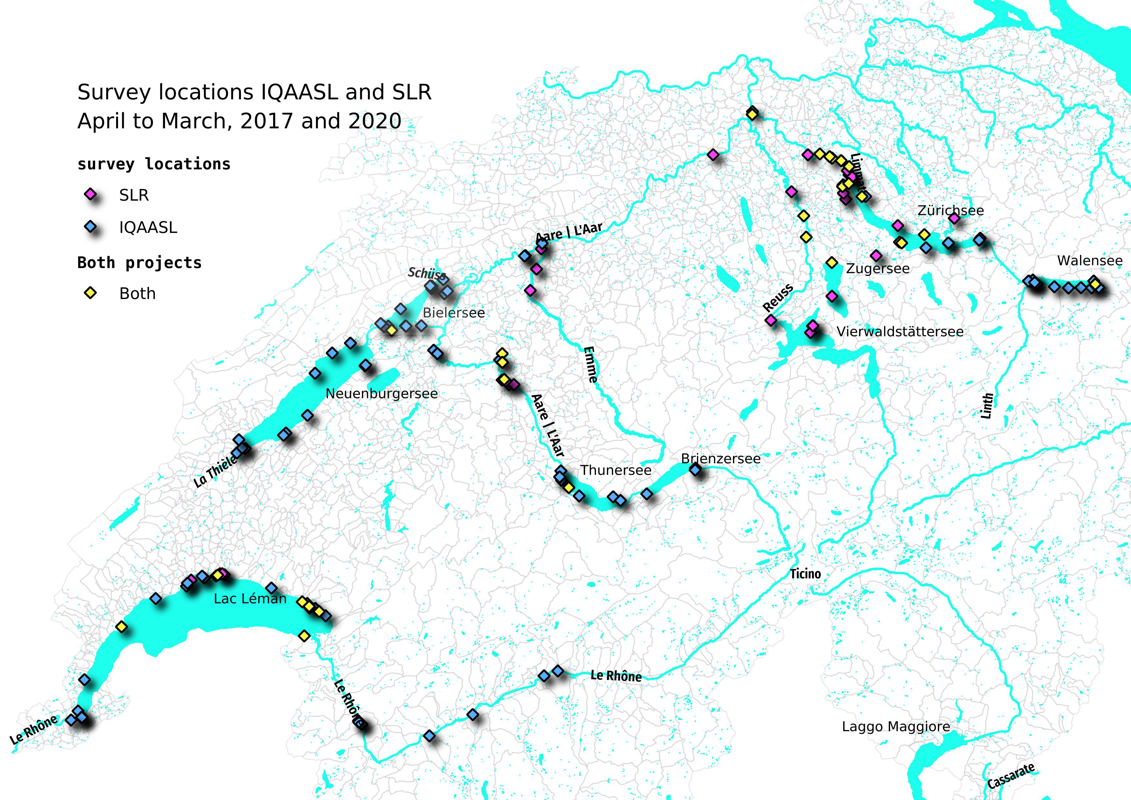

In [3]:
bassin_map = PILImage.open("resources/maps/slr_iqasl.jpeg")

output = io.BytesIO()
bassin_map.thumbnail((1200, 800))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

[Menu](#toc)<a id="summarydata"></a>
### Survey results both projects all common lakes and rivers

In [4]:
# remove the codes less than 2.5cm and industrial pellets
df = combined_data.copy()
data=df.groupby(['loc_date', 'date', 'survey year'], as_index=False)["p/100m"].sum()

# get the ecdf for both projects
ecdf_2017 = ECDF(data[data['survey year'] == '2017']['p/100m'].values)
ecdf_2020 = ECDF(data[data['survey year'] == '2020']['p/100m'].values)
ecdf_2017_x, ecdf_2017_y = ecdf_2017.x, ecdf_2017.y
ecdf_2020_x, ecdf_2020_y = ecdf_2020.x, ecdf_2020.y

# convenience func and dict to display table values
change_names = {'count':'# samples', 'mean':'average p/100m', 'std':'standard deviation', 'min p/100m':'min', '25%':'25%',  '50%':'50%', '75%':'75%', 'max':'max p/100', 'min':'min p/100', 'total objects':'total objects', '# locations':'# locations', 'survey year':'survey year'}

def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  


desc_2017 = data[data['survey year'] == '2017']['p/100m'].describe().round(2)
desc_2017['total objects'] = df[df['survey year'] == '2017'].quantity.sum()
desc_2017['# locations'] = df[df['survey year'] == '2017'].location.nunique()
desc_2017['survey year'] = '2017'
desc_2017.update({'count':int(desc_2017['count'])})

desc_2017 = pd.Series(anew_dict(desc_2017))


desc_2020 = data[data['survey year'] == '2020']['p/100m'].describe().round(2)
desc_2020['total objects'] = df[df['survey year'] == '2020'].quantity.sum()
desc_2020['# locations'] = df[df['survey year'] == '2020'].location.nunique()
desc_2020['survey year'] = '2020'

desc_2020 = pd.Series(anew_dict(desc_2020))

combined_summary = list(zip(desc_2017.index,desc_2017, desc_2020))
not_formatted = combined_summary[-1]
combined_summary = [(x[0], "{:,}".format(int(x[1])), "{:,}".format(int(x[2]))) for x in combined_summary[:-1]]
combined_summary.append(not_formatted)

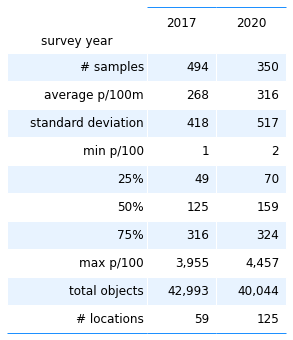

In [5]:
fig, ax = plt.subplots(figsize=(5,6))

axone = ax
ut.hide_spines_ticks_grids(axone)
a_table = axone.table(cellText=combined_summary[:-1],  colLabels=combined_summary[-1], colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],combined_summary[-1], s_et_bottom_row=True)

plt.show()

Considering only the lakes and rivers that have samples in both years there were more samples and more trash was collected from fewer locations in 2017 than 2020. However, on a pieces per meter basis the mean, median and maximum were all higher in 2020. The difference is slight and in real terms is less than 30 pieces of trash per 100m, differences of this magnitude may not be immediately discernible to the casual observer<sup>12</sup>.

Both sets of survey results are at their minimum in November through February(LOWS) and reach a maximum in April through July(HIGHS). This seasonality was noted previouslly in the SLR<sup>9</sup> and in other studies<sup>1,2</sup> outside of Switzerland. The monthly difference is greatest in August at 93pcs/100m. 

In [6]:
data.set_index('date', inplace=True)

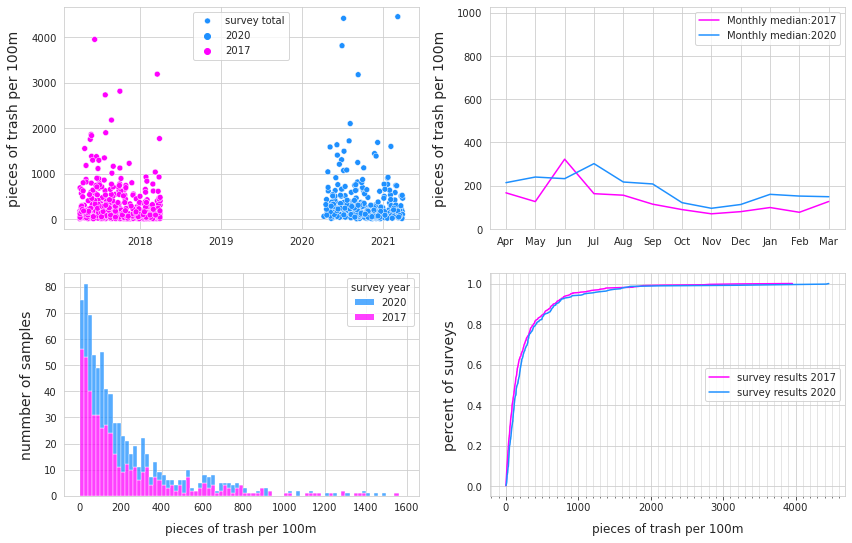

In [7]:
# the survey totals
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
years = mdates.YearLocator()


sns.set_style("whitegrid")


this_palette = {"2020":"dodgerblue", "2017":"magenta"}

the_90th = np.percentile(data['p/100m'], 95)
just_2017 = data[data['survey year'] == '2017']['p/100m'].resample('M').median()
monthly_2017 = pd.DataFrame(just_2017)
monthly_2017.reset_index(inplace=True)
monthly_2017['month'] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))


just_2020 = data[data['survey year'] == '2020']['p/100m'].resample('M').median()
monthly_2020 = pd.DataFrame(just_2020)
monthly_2020.reset_index(inplace=True)
monthly_2020['month'] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

fig, ax = plt.subplots(2,2, figsize=(14,9), sharey=False)

axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)
axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)
axone.set_xlabel(" ")

axtwo.set_xlabel(" ")
axtwo.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)

axthree.set_ylabel("nummber of samples", **ck.xlab_k14)
axthree.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

axfour.set_ylabel("percent of surveys", **ck.xlab_k14)
axfour.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

data_long = pd.melt(data[['survey year', 'loc_date', 'p/100m']],id_vars=["survey year","loc_date"], value_vars=('p/100m',), value_name="survey total")
data_long['year_bin'] = np.where(data_long['survey year'] == '2017', 0, 1)
# data_long = data_long[data_long["survey total"] < the_90th].copy()


sns.scatterplot(data=data, x='date', y='p/100m', color='red', s=34, ec='white',label="survey total", hue='survey year', palette= this_palette, ax=axone)
sns.lineplot(data=monthly_2017, x='month', y='p/100m', color='magenta', label=F"Monthly median:2017", ax=axtwo)
sns.lineplot(data=monthly_2020, x='month', y='p/100m', color='dodgerblue', label=F"Monthly median:2020", ax=axtwo)
sns.histplot(data=data_long, x='survey total', hue='survey year', stat='count', multiple='stack',palette=this_palette, ax=axthree, bins=[x*20 for x in np.arange(80)])
sns.lineplot(x=ecdf_2017_x, y=ecdf_2017_y, ax=axfour, color='magenta', label="survey results 2017")
sns.lineplot(x=ecdf_2020_x, y=ecdf_2020_y, ax=axfour, color='dodgerblue', label="survey results 2020")
axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 
axone.legend(loc='upper center')
axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which='minor',linewidth=0.5)


axtwo.set_ylim(0, the_90th)
plt.show()

In [8]:
# compare distributions:
# this is a shallow comparison because the data will be 
# seperated further in the next section

# just the survey totals

dt2017 = data[data['survey year'] == '2017']['p/100m'].to_numpy()
dt2020 = data[data['survey year'] == '2020']['p/100m'].to_numpy()
aksamp = stats.anderson_ksamp([dt2017, dt2020], midrank=False)

ecdf2017 = ECDF(dt2017)
ecdf2020 = ECDF(dt2020)

less_than_ten = df[df.length < 10].groupby('survey year').loc_date.nunique()

The distributions of the daily totals for each project have similar values. However, based on the results of the k-sample Anderson Darling test<sup>13,14</sup> (AD=3.5, p=0.0120), the null hypotheseis could be rejected. In 2017 25% of the samples were at least 50p/100m, in 2020 that decreased to 20%.  

#### The most abundant objects

The most abundant objects are those objects whose cumlative total is among the ten greatest cumulative totals for all the objects from all the surveys. The ten most abundant objects for each project was calculated, there are seven objects that make the list in both projects:

1. Fragmented plastics
2. Expanded foams
3. Snack wrappers
4. Cigarette ends
5. industrial sheeting
6. Metal bottle caps
7. Cotton swabs

*Glass pieces > 2.5cm* made the list in 2017 and *glass bottles* made the list in 2020. Alone, these 7 objects account for 57% of all objects found in 2017 and 52% in 2020.

In [9]:
tten_2017 = slr_data.groupby(['code','survey year'], as_index=False).agg({'quantity':'sum', 'fail':'sum'}).sort_values(by='quantity', ascending=False)
tten_2017['% of total'] = (tten_2017.quantity/tten_2017.quantity.sum()).round(2)
tten_2017['fail rate'] = (tten_2017.fail/desc_2017['# samples']).round(2)

tten_2020 = iqasl_data.groupby(['code','survey year'], as_index=False).agg({'quantity':'sum', 'fail':'sum'}).sort_values(by='quantity',ascending=False)
tten_2020['% of total'] = (tten_2020.quantity/tten_2020.quantity.sum()).round(2)
tten_2020['fail rate'] = (tten_2020.fail/desc_2020['# samples']).round(2)

the_combined_top_ten = set([*tten_2020.code.unique()[:10], *tten_2017.code.unique()[:10]])
intersect_top_ten = list(set(tten_2020.code.unique()[:10]) & set(tten_2017.code.unique()[:10]))

c_ten = pd.concat([tten_2017, tten_2020], ignore_index=True)

c_ten_agg =  c_ten[c_ten.code.isin(the_combined_top_ten)].groupby(['survey year', 'code', 'fail rate']).agg({'quantity':'sum', '% of total':'sum'})

c_ten_agg.reset_index(inplace=True, drop=False)
c_ten_agg['item'] = c_ten_agg.code.map(lambda x: ut.use_this_key(x, code_description_map))

cten_2017 = c_ten_agg[(c_ten_agg.code.isin(tten_2017.code.unique()[:10]))&(c_ten_agg['survey year'] == '2017')][['item', 'fail rate', 'quantity', '% of total']].sort_values(by='quantity', ascending=False)
cten_2020 = c_ten_agg[(c_ten_agg.code.isin(tten_2020.code.unique()[:10]))&(c_ten_agg['survey year'] == '2020')][['item', 'fail rate', 'quantity', '% of total']].sort_values(by='quantity', ascending=False)

In [10]:
cten_2017['fail rate'] = cten_2017['fail rate'].apply(lambda x: F"{int((x*100))}%" )
cten_2017['quantity'] = cten_2017['quantity'].apply(lambda x: "{:,}".format(x) )
cten_2017['% of total'] = cten_2017['% of total'].apply(lambda x: F"{int((x*100))}%" )

cten_2020['fail rate'] = cten_2020['fail rate'].apply(lambda x: F"{int((x*100))}%" )
cten_2020['quantity'] = cten_2020['quantity'].apply(lambda x: "{:,}".format(x) )
cten_2020['% of total'] = cten_2020['% of total'].apply(lambda x: F"{int((x*100))}%" )

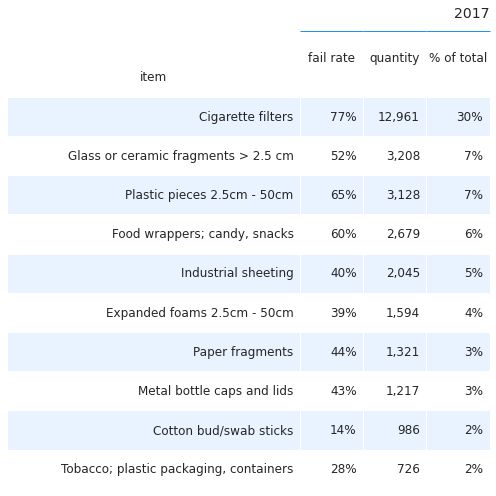

In [11]:
fig, ax = plt.subplots(figsize=(7,7))

axone = ax

ut.hide_spines_ticks_grids(axone)

axone.set_title("2017", **ck.title_k14r)
axtwo.set_title("2020", **ck.title_k14r)

a_table = axone.table(cellText=cten_2017.to_numpy(),  colLabels=cten_2017.columns, colWidths=[.6,.13,.13, .13], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,cten_2017.to_numpy(),cten_2017.columns, s_et_bottom_row=False)

plt.tight_layout()
plt.show()

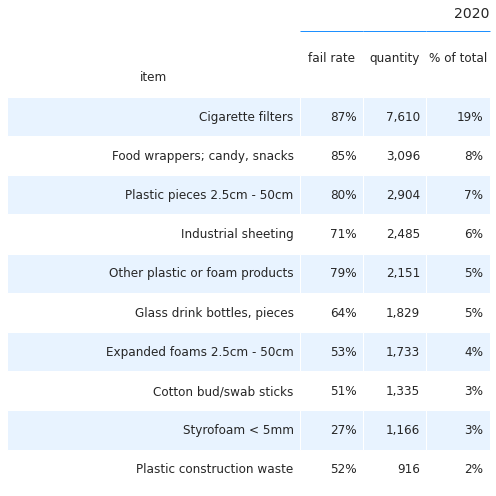

In [12]:
fig, ax = plt.subplots(figsize=(7,7))

axone = ax

ut.hide_spines_ticks_grids(axone)

axone.set_title("2020", **ck.title_k14r)

a_table = axone.table(cellText=cten_2020.to_numpy(),  colLabels=cten_2020.columns, colWidths=[.6,.13,.13, .13], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,cten_2020.to_numpy(),cten_2020.columns, s_et_bottom_row=False)

plt.tight_layout()
plt.show()

However similar the results are, the difference in sampling conditions between rivers and lakes can not be overlooked nor the effects those conditions may have on survey totals. 

[Menu](#toc)<a id="thelakes"></a>

### Comparing lakes 2017 - 2020

When possible the SLR locations were resampled in IQAASL, in most cases multiple times. The following lakes were sampled in both project years:

1. Zurichsee
2. Bielersee
3. Neuenburgersee
4. Walensee
5. Lac Léman
6. Thunersee

#### Locations sampled: lakes 2017 - 2020

In IQAASL the priority was given to locations that had data from previous sample. At the same time it was necessary to increase the number of sample locations per lake. There were 70 different survey locations in 2020 versus 22 in 2017, 16/22 locations were resampled in 2020 and four locations did not meet the sampling criteria. Of the 282 samples in 2020 100 were from locations that had been sampled in 2017.

In [13]:
lks_df = df[df.water_name_slug.isin(these_lakes)].drop_duplicates().copy()
lks_df.rename(columns={'str_rank':'street rank'}, inplace=True)
lks_df['streets km'] = lks_df.streets/1000

lks_dt = lks_df.groupby(['survey year', 'water_name_slug','loc_date','date', 'month'], as_index=False)['p/100m'].sum()
com_locs_df = lks_df[lks_df.location.isin(locations_in_both)].copy()
nsamps_com_locs = com_locs_df[com_locs_df['survey year'] == '2020'].groupby(['location'], as_index=True).loc_date.nunique()

com_locs_20 = com_locs_df[com_locs_df['survey year'] == '2020'].location.unique()
locs_lakes = lks_df[lks_df['survey year'] == '2020'].location.unique()
# lks_ma = lks_df[lks_df.code.isin(the_combined_top_ten)].copy()

<a id="luseprofile"></a>
#### Land use profile of survey locations

Land use attributes are measurable properties that are geolocated and can be extracted from the current versions of Statistique suisse de la superficie<sup>17</sup> and swissTlmRegio<sup>18</sup>.


**Calculating land use:** The Office fédéral de la statistique provides the 'Statistique de superficie'<sup>17</sup>, a grid of points 100m x 100m that covers Switzerland. Each point is assigned one of 72 different land use categories. The number and catgeory of those points within a 1500m radius of each survey location was calculated. The river discharge points and length of road ways was calculated by using the relevant map layers from swissTLMRegio<sup>18</sup> and extracting those values using QGISv3.1.

The land use profile *within 1500 meters around each survey location* was evaluated for the following criteria:

1. % of surface area attributed to buildings
2. % of surface area left to woods
3. % of surface area attributed to outdoor activities
4. % of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

The land use is reported as the percent of total surface area attributed to each land use category within a 1500m radius of the survey location. Street rank is the ordinal ranking of the length of all streets/pathways within the 1500m buffer.  Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.
For more information see the section *land use correlation*.

<span style="color:red">No land use data for Walensee:</span> As of June 22, 2021 the land use data for Walensee was not up to date. It is there for excluded from the land use profile description.

In [14]:
# no_wsee = lks_df[lks_df.water_name_slug != 'walensee']
# bs = no_wsee[no_wsee['survey year']=="2017"].groupby(["survey year", "% to buildings"], as_index=False).loc_date.nunique()

Land use profile 2017 and 2020

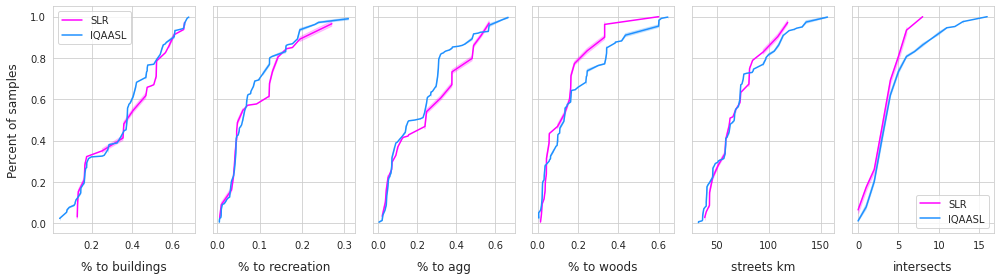

In [15]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','water_name_slug','streets km', 'intersects', 'groupname','code']

# group the explanatory variables and count the number of surveys for the different landuse values
lks_df.rename(columns={'str_rank':'street rank'}, inplace=True)

fig, axs = plt.subplots(1, len(luse_exp), figsize=(14,4), sharey='row')

data=lks_df[(lks_df['survey year'] == '2017')&(lks_df.water_name_slug != 'walensee')].groupby(use_these_cols[:-2], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})
data2=lks_df[(lks_df['survey year'] == '2020')&(lks_df.water_name_slug != 'walensee')].groupby(use_these_cols[:-2], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})

for i, n in enumerate(luse_exp):
    ax=axs[i]
    the_data = ECDF(data[n].values)
    x, y = the_data.x, the_data.y
    
    the_data2 = ECDF(data2[n].values)
    x2, y2 = the_data2.x, the_data2.y
    
    
    sns.lineplot(x=x, y=y, ax=ax, color='magenta', label="SLR")
    sns.lineplot(x=x2, y=y2,ax=ax, color='dodgerblue', label="IQAASL")
    if i == 0:
        handles, labels=ax.get_legend_handles_labels() 
        ax.legend(handles, labels, loc='upper left')
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(n, **ck.xlab_k)
    
handles, labels=ax.get_legend_handles_labels() 
ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show()

For both projects 50% of the samples had less than ~36% of land attributed to buildings,  less than ~5% attributed to recreation and less than ~10% attributed to woods or forest. In 2017 50% of the samples had less than ~25% of land attributed to agriculture versus ~14% for 2020. 

The length of the road network within the buffer zone differentiates between locations that have other wise similar land use characteristics. The range of the road network inside each 1500m buffer was 32km to 156km. In both years 50% of the samples came from locations that had 63km of roads or less within 1500m of the survey location. 

The number of river or canal intersections ranges from zero to 16, 50% of the surveys had 3 or fewer intersections within 1500m of the survey location in both years. The size of the intersecting river or canal was not taken into consideration. Survey locations on rivers have zero intersections.

The population (not shown) is taken from statpop 2018<sup>28</sup> and represents the population of the municipality surounding the survey location. The smallest population was 442 and the largest was 415,357. At least 50% of the samples came from municipalities with a population of ~13000 or less.

If % of land use attributed to agriculture is a sign of urbanization then the survey areas in 2020 were slightly more urban than 2017. 

[Menu](#toc)<a id="thelakessum"></a>

#### Survey results lakes

When just the six lakes are considered there were more samples, more locations and more trash was collected in 2020, but the median and average were both lower with respect to 2017. The seasonality previously observed remains, including the spike in june 2017.

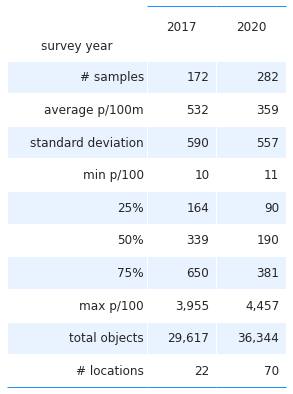

In [16]:
desc_2017 = lks_dt[lks_dt['survey year'] == '2017']['p/100m'].describe().round(2)
desc_2017['total objects'] = lks_df[lks_df['survey year'] == '2017'].quantity.sum()
desc_2017['# locations'] = lks_df[lks_df['survey year'] == '2017'].location.nunique()
desc_2017['survey year'] = '2017'

desc_2017 = pd.Series(anew_dict(desc_2017))


desc_2020 = lks_dt[lks_dt['survey year'] == '2020']['p/100m'].describe().round(2)
desc_2020['total objects'] = lks_df[lks_df['survey year'] == '2020'].quantity.sum()
desc_2020['# locations'] = lks_df[lks_df['survey year'] == '2020'].location.nunique()
desc_2020['survey year'] = '2020'
desc_2020 = pd.Series(anew_dict(desc_2020))

combined_summary = list(zip(desc_2017.index,desc_2017, desc_2020))
not_formatted = combined_summary[-1]
combined_summary = [(x[0], "{:,}".format(int(x[1])), "{:,}".format(int(x[2]))) for x in combined_summary[:-1]]
combined_summary.append(not_formatted)

fig, ax = plt.subplots(figsize=(5,7))

axone = ax
ut.hide_spines_ticks_grids(axone)
a_table = axone.table(cellText=combined_summary[:-1],  colLabels=combined_summary[-1], colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],combined_summary[-1], s_et_bottom_row=True)

plt.show()

In [17]:
# the_90th = np.percentile(data['p/100m'], 95)
# just_2017 = data[data['survey year'] == '2017']['p/100m'].resample('M').median()
# monthly_2017 = pd.DataFrame(just_2017)
# monthly_2017.reset_index(inplace=True)
# monthly_2017['month'] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))


# just_2020 = data[data['survey year'] == '2020']['p/100m'].resample('M').median()
# monthly_2020 = pd.DataFrame(just_2020)
# monthly_2020.reset_index(inplace=True)
# monthly_2020['month'] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

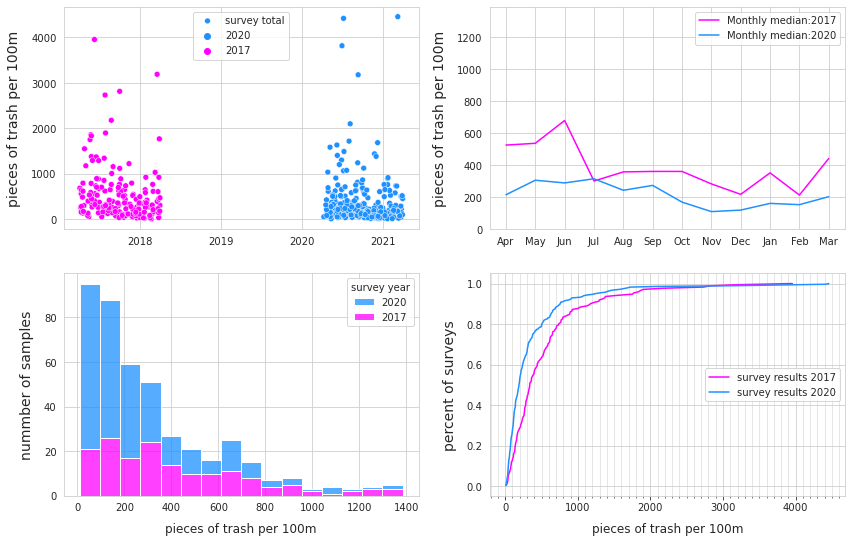

In [18]:
# the monthly average
data=lks_df.groupby(['loc_date', 'date', 'survey year'], as_index=False)['p/100m'].sum()
data.set_index('date', inplace=True)

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
years = mdates.YearLocator()

ecdf_2017 = ECDF(data[data['survey year'] == '2017']['p/100m'].values)
ecdf_2020 = ECDF(data[data['survey year'] == '2020']['p/100m'].values)
ecdf_2017_x, ecdf_2017_y = ecdf_2017.x, ecdf_2017.y
ecdf_2020_x, ecdf_2020_y = ecdf_2020.x, ecdf_2020.y

the_90th = np.percentile(data['p/100m'], 95)
just_2017 = data[data['survey year'] == '2017']['p/100m'].resample('M').median()
monthly_2017 = pd.DataFrame(just_2017)
monthly_2017.reset_index(inplace=True)
monthly_2017['month'] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))

just_2020 = data[data['survey year'] == '2020']['p/100m'].resample('M').median()
monthly_2020 = pd.DataFrame(just_2020)
monthly_2020.reset_index(inplace=True)
monthly_2020['month'] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

data_long = pd.melt(data[['survey year', 'p/100m']],id_vars=["survey year"], value_vars=('p/100m',), value_name="survey total")
data_long['year_bin'] = np.where(data_long['survey year'] == '2017', 0, 1)
data_long = data_long[data_long["survey total"] < the_90th].copy()

fig, ax = plt.subplots(2,2, figsize=(14,9), sharey=False)
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)
axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)
axone.set_xlabel(" ")

axtwo.set_xlabel(" ")
axtwo.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)

axthree.set_ylabel("nummber of samples", **ck.xlab_k14)
axthree.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

axfour.set_ylabel("percent of surveys", **ck.xlab_k14)
axfour.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

sns.scatterplot(data=data, x='date', y='p/100m', color='red', s=34, ec='white',label="survey total", hue='survey year', palette= this_palette, ax=axone)

sns.lineplot(data=monthly_2017, x='month', y='p/100m', color='magenta', label=F"Monthly median:2017", ax=axtwo)
sns.lineplot(data=monthly_2020, x='month', y='p/100m', color='dodgerblue',label=F"Monthly median:2020",  ax=axtwo)

sns.histplot(data=data_long, x='survey total', hue='survey year', stat='count', multiple='stack', palette=this_palette, ax=axthree)

sns.lineplot(x=ecdf_2017_x, y=ecdf_2017_y, ax=axfour, color='magenta', label="survey results 2017")
sns.lineplot(x=ecdf_2020_x, y=ecdf_2020_y, ax=axfour, color='dodgerblue', label="survey results 2020")
axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 
axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which='minor',linewidth=0.5)


axone.legend(loc='upper center')


axtwo.set_ylim(0, the_90th)
plt.show()

Under similar sampling conditions the distribution of the survey results diverge. When just the lakes are considered only ~5% of the surveys had less than 50pcs/100m in 2017 and ~13% in 2020. These results also also add weight to the previous result for the k-sample Anderson Darling test, it is not likely that these results come from the same distribution (AD=20.9, p=0.001)<sup>13,14</sup>.

In [19]:
%%capture
dt2017 = data[data['survey year'] == '2017']['p/100m'].to_numpy()
dt2020 = data[data['survey year'] == '2020']['p/100m'].to_numpy()
aksamp = stats.anderson_ksamp([dt2017, dt2020], midrank=False);


# ecdf2017 = ECDF(dt2017)
# ecdf2020 = ECDF(dt2020)

[Menu](#toc)<a id="themostcommon"></a>
### Most common objects

The most common objects are defined as **those objects that were found in at least 50% of the samples (fail rate) and/or whose total quantity is in the top ten** for the time frame and region. The most common objects were calculated by combining the most abundant objects for each project and then selecting all the objects that were found in at least 50% of all surveys in either project. The resulting list has sixteen objects that reflect **the most abundant and most frequently identified objects from both projects**<sup>16</sup>.

#### Most commom objects survey results 2017 - 2020

From 2017 - 2020 the median p/100m per survey decreased in 9/16 of the most common objects or ~60% of all objects found in 2017. At the same time the the fail rate increased for 10/16 of the most common objects. Cigarette ends, fragmented plastics and aluminum foil wrappers were found more frequently in 2020 but in lower quantities than 2017. 

In [20]:
lks_codes = lks_df.groupby(['code', 'survey year'], as_index=False).agg({'p/100m':'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})

In [21]:
lks_codes = lks_df.groupby(['code', 'survey year'], as_index=False).agg({'p/100m':'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})
lks_codes.loc[lks_codes['survey year'] == '2020', 'fail rate'] = lks_codes.fail/desc_2020['# samples']
lks_codes.loc[lks_codes['survey year'] == '2017', '% of total'] = lks_codes.quantity/desc_2017['total objects']
lks_codes.loc[lks_codes['survey year'] == '2017', 'fail rate'] = lks_codes.fail/desc_2017['# samples']
lks_codes.loc[lks_codes['survey year'] == '2020', '% of total'] = lks_codes.quantity/desc_2020['total objects']
# the_top ten:
lks_tten = lks_codes.sort_values(by='quantity', ascending=False)

tten_2017 = lks_tten[lks_tten['survey year']=='2017'][:10].code.values
grtr_502017 = lks_codes[lks_codes['survey year']=='2017'].sort_values(by='fail rate', ascending=False)[:10].code.values

tten_2020 = lks_tten[lks_tten['survey year']=='2020'][:10].code.values
grtr_502020 = lks_codes[lks_codes['survey year']=='2020'].sort_values(by='fail rate', ascending=False)[:10].code.values

most_common_2017 = list(set([*tten_2017, *grtr_502017]))
most_common_2020 = list(set([*tten_2020, *grtr_502020]))

mc_2017_2020 = set([*most_common_2017, *most_common_2020])
pivot_2017_2020 = lks_codes[lks_codes.code.isin(mc_2017_2020)].pivot(columns='survey year', values=['p/100m', 'fail rate', '% of total'], index='code')
pivot_2017_2020['Item'] = pivot_2017_2020.index.map(lambda x: ut.use_this_key(x, code_description_map))
pivot_2017_2020.set_index('Item', inplace=True, drop=True)
# pivot_2017_2020

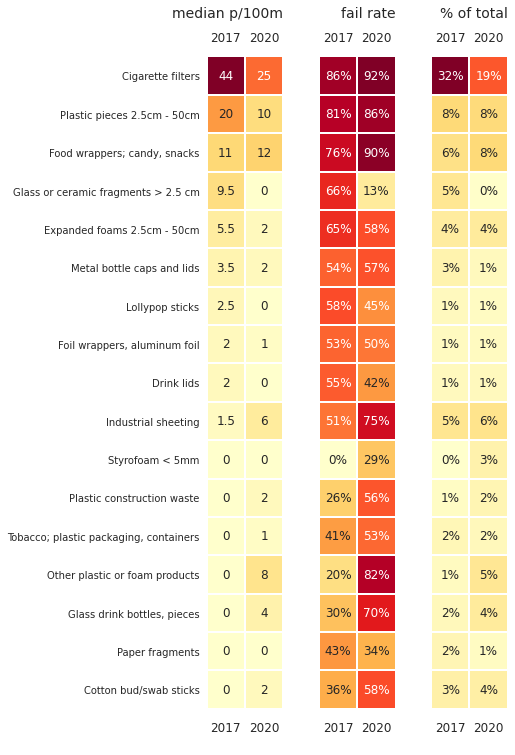

In [22]:
# plot that
fig = plt.figure(figsize=(8, 12))

spec = GridSpec(ncols=8, nrows=2, figure=fig)
axone = fig.add_subplot(spec[:,1:3])
axtwo = fig.add_subplot(spec[:,3:5])
axthree = fig.add_subplot(spec[:,5:7])
an_order = pivot_2017_2020['p/100m'].sort_values(by='2017', ascending=False).index
axtwo_data = pivot_2017_2020['fail rate'].sort_values(by='2017', ascending=False).reindex(an_order)
axthree_data = pivot_2017_2020['% of total'].sort_values(by='2017', ascending=False).reindex(an_order)


sns.heatmap(pivot_2017_2020['p/100m'].sort_values(by='2017', ascending=False), cmap='YlOrRd', annot=True, annot_kws={'fontsize':12},  ax=axone, square=True, cbar=False, linewidth=.05,  linecolor='white')
axone.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axone.set_xlabel(" ")
axone.set_title("median p/100m",**ck.title_k14r)

sns.heatmap(axtwo_data, cmap='YlOrRd', annot=True, annot_kws={'fontsize':12}, fmt='.0%', ax=axtwo, square=True,  cbar=False, linewidth=.05,  linecolor='white')
axtwo.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axtwo.tick_params(labelleft=False, left=False)
axtwo.set_xlabel(" ")
axtwo.set_title("fail rate", **ck.title_k14r)

sns.heatmap(axthree_data, cmap='YlOrRd', annot=True, annot_kws={'fontsize':12}, fmt='.0%', ax=axthree, square=True,  cbar=False, linewidth=.05,  linecolor='white')
axthree.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axthree.tick_params(labelleft=False, left=False)
axthree.set_xlabel(' ')
axthree.set_title("% of total", **ck.title_k14r)


axone.set_ylabel("")
axtwo.set_ylabel("")
axthree.set_ylabel("")


plt.subplots_adjust(wspace=0.05)
plt.show()

In [23]:
small = lks_df[lks_df.code.isin([ "G20", "G21", "G22", "G23"])].groupby(['code', 'survey year'], as_index=False).agg({'quantity':'sum', 'p/100m':'mean'})
ttl = combined_data.groupby('survey year').quantity.sum()
small.loc[small['survey year'] == '2017', 'p_t'] = small.quantity/ttl.loc['2017']
small.loc[small['survey year'] == '2020', 'p_t'] = small.quantity/ttl.loc['2020']

# print(small.groupby(['survey year','code']).sum())
# print(small.groupby(['survey year']).sum())

#### Size matters

There was a key difference between the two protocols:

* The 2020 protocol counts all visible objects and classifies fragments by size
* The 2017 protocol limited the object counts to items greater than or equal to 2.5cm in length

This difference in protocol effects the interpretation of the results for fragmented plastics and expanded foams from one year to the next.  Expanded foams and fragmented plastics are objects whose original use is unknown but the material can be distinguished. **Fragmented plastics and expanded foams of all sizes are 28% of the total survey results for the lakes in 2020 and half of which are unaccounted for in 2017**<sup>15</sup>.  

#### Surveyors paradox

Size limitations increase the complexity of the survey process by introducing another step. If not carefully implemented limitations add a paradox that each surveyor must confront when objects that have been identified do not meet the size criteria of the protocol:

* either leave the material and not count it 
* take it and not count it

The surveyor is being asked to either ignore objects that are there or remove the objects and not quantify them. Either way it does not fully describe the situation and it leaves work undone. A moral impass for the litter surveyor.

If their are size limits in the protocol then certain objects have to be measured. Whether an object is counted or not depends on if their is a category to place it in. The MSFD provides codes to classify objects as small as 5mm, the 2020 project takes advantage of this in order to account for as much material as possible. **Thus avoiding the paradox** and providing a more detailed survey.

#### Plastic lids and plastic lids

Plastic lids are seperated into three catgegories during the counting process:

1. drink, food 
2. household cleaners etc..
3. unknown

As a group plastic lids make up 2% of the total objects in 2017 and 3% in 2020. Drink lids were ~51% of all lids found in 2017, 45% in 2020. On a pieces per meter basis there was a decrease in the amount of drink lids and an increase of non-drink lids.

[Menu](#toc)<a id="seasonalvariation"></a>
#### Seasonal variations

All lakes were sampled in all months in both projcets. In 2017 the minimum samples per month  was 12 and the maximum was 17 compared to a minimum of 17 and max of 34 in 2020.

In [24]:
top_ten_month = lks_df[(lks_df['survey year'] == '2017')&(lks_df.code.isin(mc_2017_2020))].groupby(['loc_date', 'date', 'code'], as_index=False)['p/100m'].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)
group_names =  ['G67', 'G79', 'G82', 'G89','G124', 'G95','G156', 'G177', 'G178', 'G200', 'G208', 'G30', 'G31', 'G21', 'G25', 'G27']

mgr = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]['p/100m'].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

Median monthly results most common objects 2017

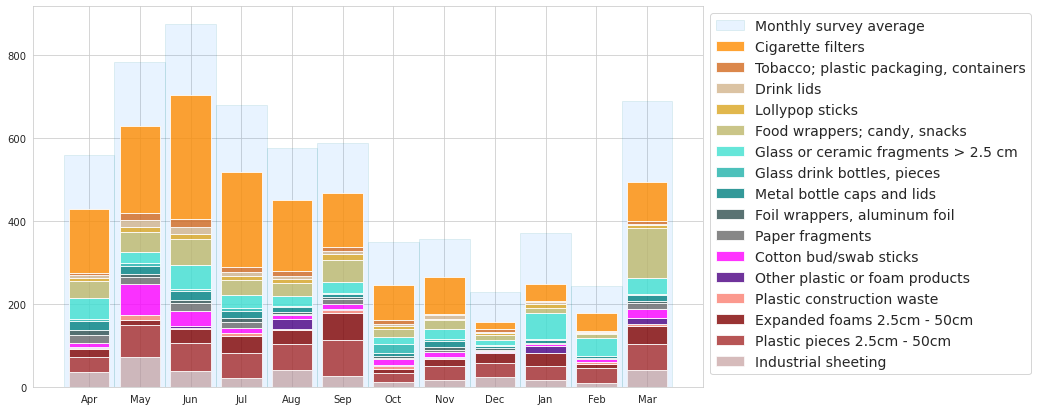

In [25]:
fig, ax = plt.subplots(figsize=(12,7))

colors_palette = {'G156':'dimgray', 'G178': 'teal',
    'G177': 'darkslategray',
    'G200': 'lightseagreen',
    'G27':'darkorange',
    'G30':'darkkhaki',
    'G67':'rosybrown',
    'G89': 'salmon',
    'G95':'magenta',
    'G82': 'maroon',
    'G79':'brown',
    'G208': 'turquoise',
    'G124':'indigo',
    'G25': 'chocolate',
    'G31': 'goldenrod',
    'G21': 'tan'    
}
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

bottom = [0]*len(mgr['G27'])

hmm = lks_df[lks_df['survey year'] == '2017'].groupby(['loc_date', 'date'], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})
hmm.set_index('date', inplace=True)
hmmx2017 = hmm['p/100m'].resample('M').mean().fillna(0)

this_x = [i for i,x in  enumerate(hmmx2017.index)]
ax.bar(this_x, hmmx2017.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average") 


for i, a_group in enumerate(group_names):
       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    else:
        bottom += mgr[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)


new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("")

    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

Of the sixteen most common objects from the two projects 13 have a decrease in the median p/100m per survey from HIGHS to LOWS. Cigarette ends, metal tops, candy wrappers and tobacco packaging register a median decrease of > 60% from HIGHS to LOWS in both projects. Three objects that had a net increase from HIGHS to LOWS: the glass objects: *bottles and pieces* and *glass pieces > 2.5cm* and *other plastic or foam products*.

Median monthly results most common objects 2020

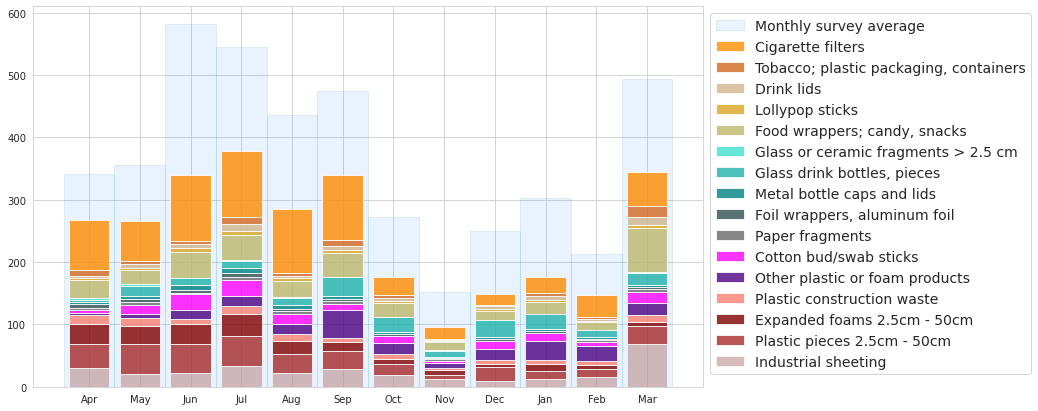

In [26]:
top_ten_month = lks_df[(lks_df['survey year'] == '2020')&(lks_df.code.isin(mc_2017_2020))].groupby(['loc_date', 'date', 'code'], as_index=False)['p/100m'].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)

mgr2020 = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]['p/100m'].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr2020.update(this_group)
fig, ax = plt.subplots(figsize=(12,7))

bottom = [0]*len(mgr2020['G27'])

hmm = lks_df[lks_df['survey year'] == '2020'].groupby(['loc_date', 'date'], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})
hmm.set_index('date', inplace=True)
hmmx2020 = hmm['p/100m'].resample('M').mean().fillna(0)

this_x = [i for i,x in  enumerate(hmmx2020.index)]
ax.bar(this_x, hmmx2020.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average") 

for i, a_group in enumerate(group_names):
       
    
    this_x = [i for i,x in  enumerate(mgr2020[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr2020[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr2020[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6) 
    else:
        bottom += mgr2020[group_names[i-1]].to_numpy()
        
        ax.bar(this_x, mgr2020[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[x-1] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)


new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("", **ck.title_k14)

    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

As the difference between HIGHS and LOWS changes the amount and type of objects likely to be found at a survey site changes. This change effects some objects more than others, cigarette ends, expanded foams, metal bottle tops, tobacco packaging, snack wrappers and fragmented plastics had the greatest decrease from HIGHS to LOWS. Apart from expanded foams and fragmented plastics, these objects are products that can be purchased within 1500m of all but the more secluded survey locations.

In [27]:
mins20 = ["2020-11-30", "2021-02-28", "2020-12-31", "2021-01-31"]
maxs20 = ["2020-06-30", "2020-07-31", "2020-08-31", "2020-09-30"]

mins17 = ["2017-11-30", "2018-02-28", "2017-12-31", "2018-01-31"]
maxs17 = ["2017-06-30", "2017-07-31", "2017-08-31", "2017-09-30"]
cont = ["G27", "G30","G21"]
dist = ["G89", "G67", "G95", "G82", "G79"]

monthly_results_most_common = {'2017':mgr,'2020':mgr2020}
dates_min_max = {"2017":{"min":mins17, "max":maxs17}, "2020":{"min":mins20, "max":maxs20}}

a_bucket = []
for year in ['2017', '2020']:
    data = monthly_results_most_common[year]
    dates = dates_min_max[year]
    for element in group_names:
        decrease = (data[element].loc[dates['max']].median() - data[element].loc[dates['min']].median())/data[element].loc[dates['max']].median()
        a_bin = {"survey year":year, "code":element, "max - min":decrease*-1}
        a_bucket.append(a_bin)
        
        
# dfCodes.loc[group_names]   
highs_to_lows = pd.DataFrame(a_bucket).pivot(columns="survey year", values="max - min", index='code').sort_values(by='2017')
# highs_to_lows.apply(lambda x: np.round(x*100, 'int'))
h_to_l = highs_to_lows.apply(lambda x: (x*100).astype('int'))
h_to_l['2017'] = h_to_l['2017'].apply(lambda x:F"{x}%")
h_to_l['2020'] = h_to_l['2020'].apply(lambda x:F"{x}%")
h_to_l['item'] = h_to_l.index.map(lambda x: ut.use_this_key(x, code_description_map))
# h_to_l = h_to_l.apply(lambda x: F"{x}%")
h_to_l.set_index('item', drop=True, inplace=True)
h_to_l.reset_index(inplace=True)
cols = h_to_l.columns


Change from HIGH months to LOW months

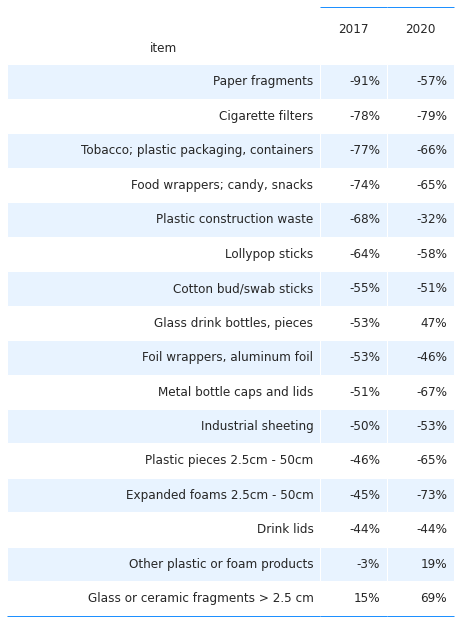

In [28]:
fig, ax = plt.subplots(figsize=(8,len(h_to_l)*.7))

axone = ax
ut.hide_spines_ticks_grids(axone)
a_table = axone.table(cellText=h_to_l.values,  colLabels=cols, colWidths=[.7,.15,.15], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,h_to_l.values,cols, s_et_bottom_row=True)

plt.show()

With respect to 2017, when locations with similar sampling conditions and the most common objects are considered the seasonal effects on the amounts of visible trash can be quantified. Both projects register a decrease from HIGH to LOW for 14/16 of the most common objects. Even objects that show an increase in p/100m from 2017 to 2018 show the same seasonal trends.

[Menu](#toc)<a id="luse"></a>

#### Land use features and the most common objects

The land use features were previously calculated to compare the survey locations. The results of those calculations were also compared to the survey totals for each location. The survey totals and locations from both projects were considered as one group. The method used is the Spearman's rho or *Spearmans ranked correlation coefficient*<sup>20</sup>. The test results are evaluated at p<0.05 and 454 samples.

1. Red/rose is a postitive correlation
2. yellow is negative
3. white means that p>0.05, there is no statisitical basis to assume a correlation<sup>20</sup>.

A correlation suggests that survey totals for that object will change in relation to the amount space attributed to that feature, or in the case of roads or river intersections, the quantity. The magnitude of the relationship is not defined and any correlation is most likely not linear. 

In [29]:
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y='p/100m', ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr = stats.spearmanr(data[n], data['p/100m']).correlation
    a_p = stats.spearmanr(data[n], data['p/100m']).pvalue
    return ax, corr, a_p
corr_data = lks_df[(lks_df.code.isin(mc_2017_2020))].copy()
corr_data = corr_data[corr_data.water_name_slug != 'walensee']

# corr_data.rename(columns={'str_rank':'street rank'}, inplace=True)
code_fails = corr_data.groupby('code').fail.sum()

# the ratio of found/not found
code_fail_rate = code_fails/lks_df.loc_date.nunique()



# all codes with a fail rate > fail rate
better_than_50 = code_fail_rate

some_keys = {
    '% to buildings':'lu_build',
    '% to agg':'lu_agg',
    '% to woods':'lu_woods',
    '% to recreation':'lu_rec',
    '% to trans':'lu_trans',
    '% to meadow':'lu_m',
    'str_rank':'lu_trans',}

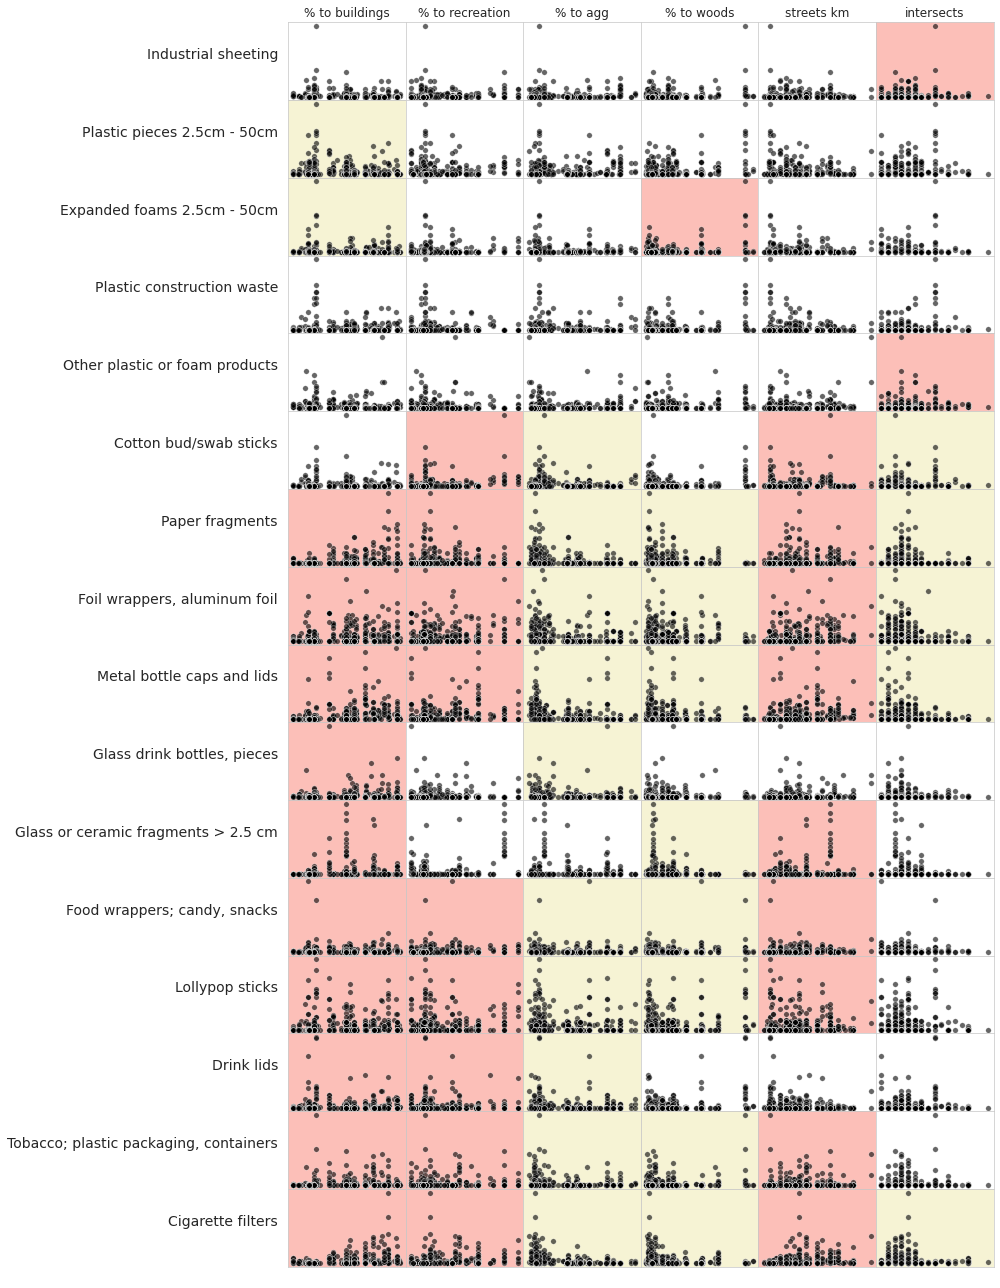

In [30]:
fig, axs = plt.subplots(len(['G67', 'G79', 'G82', 'G89','G124', 'G95','G156', 'G177', 'G178', 'G200', 'G208', 'G30', 'G31', 'G21', 'G25', 'G27']),len(luse_exp), figsize=(len(luse_exp)+8,len(mc_2017_2020)+1), sharey='row')

for i,code in enumerate(['G67', 'G79', 'G82', 'G89','G124', 'G95','G156', 'G177', 'G178', 'G200', 'G208', 'G30', 'G31', 'G21', 'G25', 'G27']):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)
# plt.tick_params(labelsize=14, which='both', axis='both')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

#### Correlated values

**Interpreting results** 

The correlation results should allways be considered in conjuction with all the key indicators. 

1. A positive correlation means that the land use feature facilitates the accumulation or deposition of that particlualr object. This may be due to a covariance of attributes, either way **a positive correlation is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators at the responsible administrative level.

2. A negative correlation means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for aggricultural areas and woods on the national level. **A negative correlation is a signal that the locations are not a zone of accumulation for the object**.

3. No correlation means that the land use attribute or feature had no accumulating effect on the survey results for that object. The fail rate of the objects with none or few correlations should be consulted, especially when considering the most common objects:

   1. Objects that have few correlations and a high fail **rate are ubiquitous**
   2. Objects that have few correlations, low fail rate and high p/100m **maybe close to a source**
   
In the 2017 project it was conlcuded that the average litter density increased in urbain zones compared to rural or peri-urban zones, stating that the number of visitors to a site is an important factor in the density of trash<sup>8</sup>. The results of the correlation test support this hypothesis for specific objects:

1. Cigarette ends
2. Snack wrappers
3. Paper fragments
4. Tobacco packaging
5. Foil wrappers
6. Lolypop sticks
7. Metal bottle caps
8. Plastic drink lids
9. Foil wrappers

These objects are among the most common in both projects, they all correlate positively with the % of land attributed to buildings, streets and recreation areas and negatively with % of land attributed to agrculture or woods. Combined with the observed effects of seasonality the evidence suggests that these objects were most likely left on site or within close proximity. 

On the other hand, the following objects have few correlations a high fail rate and an elevated pcs/100m:

1. Fragmented plastics
2. Expanded foams
3. Plastic construction waste
4. Other plastic or foam products
5. Industrial sheeting

These objects meet criteria three. In general they are found at all locations and there is not a measured land use attribute that statistically establishes a correlation.

In [31]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-07-05.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


[top](#toc)<a id="annex"></a>
### Annex

1. [IQAASL surveyors](#us)
2. [Notes](#notes)
3. [Survey locations](#gps)


[annex](#annex)<a id="us"></a>
#### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

[annex](#annex)<a id="notes"></a>

#### Notes:

<sup>1</sup> Marine debris in central California: Quantifying type and abundance of beach litter in Monterey Bay, CA. Available from: https://www.researchgate.net/publication/236053935_Marine_debris_in_central_California_Quantifying_type_and_abundance_of_beach_litter_in_Monterey_Bay_CA [accessed Jun 24 2021].

> Marginal heterogeneity was found between different types of litter across month and location. These results indicate litter type is significantly different among months and beach locations(p< 0.01). 

> Because the majority of Styrofoam observed in our surveys was broken-up (5 mm–5 cm), it was nearly impossibleto identify the whole source product from these fragments (i.e.,to-go containers, cups, plates, coolers, and commercial packingmaterial).

<sup>2</sup> S. Miladinova, D. Macias, A. Stips, E. Garcia-Gorriz, Identifying distribution and accumulation patterns of floating marine debris in the Black Sea, Marine Pollution Bulletin, Volume 153, 2020,110964,
ISSN 0025-326X,https://doi.org/10.1016/j.marpolbul.2020.110964. (https://www.sciencedirect.com/science/article/pii/S0025326X20300825)

> Snowmelt and heavy rainfall during this period are thought to be key factors in carrying litter to the sea, as river discharge in this area is usually low at other times of the year.

> Monitoring of marine litter along the Bulgarian Black Sea coast (Simeonova et al., 2017) shows that the beaches are highly polluted due to local sources, where cigarette butts and filters (OSPAR-code 64) are dominant. Since the highest marine litter accumulation is observed in summer, one can conclude that the accumulation is probably a result of recreational activities, increased tourist flow and wild camping.

> Debris of terrestrial origin reaches the Black Sea mainly through runoff; via storm drains and waterways accessing areas where garbage is not adequately controlled

> We choose these two particle behaviours to calculate separately the litter accumulation zones when the litter does not accumulate on the beach (bouncing behaviour) and when the litter particles that reach the beach do not return back to the sea (beaching behaviour).

<sup>3</sup> van Emmerik, T., Strady, E., Kieu-Le, TC. et al. Seasonality of riverine macroplastic transport. Sci Rep 9, 13549 (2019). https://doi.org/10.1038/s41598-019-50096-1

> The abundance of plastics seems to be related to the concentration of organic material in the Saigon River. Most organic material was identified as water hyacinths. Water hyacinths often form large patches with plastic floating on its surface or trapped in the roots and thus seem to function as accumulation zones for plastic material.

<sup>4</sup> GESAMP. Sources, fate and effects of microplastics in the marine environment: part two of a global assessment (eds Kershaw, P. J. & Rochman, C. M.). (IMO/FAO/UNESCO-IOC/UNIDO/WMO/IAEA/UN/UNEP/UNDP Joint Group of Experts on the Scientific Aspects of Marine Environmental Protection). Rep. Stud. GESAMP 93, 220 (2016).

> Land-based sources, as opposed to marine-based sources, are considered the dominant input of plastics into oceans

<sup>5</sup> Lebreton, L., van der Zwet, J., Damsteeg, JW. et al. River plastic emissions to the world’s oceans. Nat Commun 8, 15611 (2017). https://doi.org/10.1038/ncomms15611

> Overall, observed plastic concentrations differ by several orders of magnitude in between sampled rivers, with studies suggesting that population density, levels of urbanization and industrialization within catchment areas, rainfall rates and the presence of artificial barriers such as weirs and dams play a significant role in resulting rates of river-based plastic inputs into the ocean.

<sup>6</sup> Wagner, M. et al. Microplastics in freshwater ecosystems: what we know and what we need to know. Environ. Sci. Eur. 26, 12 (2014).

<sup>7</sup> Spatio-temporal variability of beached macro-litter on remote islands of the North Atlantic, Noelia Ríosa,1, João P.G.L. Friasb,d,1, Yasmina Rodríguezc,d, Rita Carriçoc,d, Sofia M. Garciae,Manuela Julianoc, Christopher K. Pham

> For rocky and gravel beaches, plastic/polystyrenefragments between 2.5 and 50 cm were more prevalent. In opposition,plastic/polystyrene fragments between 2.1 and 2.5 cm were pre-dominant in sandy beaches while larger fragments (found to be morefrequent in gravel and rocky shores)

<sup>8</sup> Pascal Blarer, Gabriele Kull, The Swiss Litter Report, June 2108, Zurich, http://stoppp.org/research

> Between April 2017 and March 2018 1,052 measurements were made at 112 locations for the Swiss Litter Report. More than 150 trained volunteers collected and categorized 95,971 pieces of litter from the shores of the largest rivers and lakes in Switzerland. This makes the Swiss Litter Report one of the most comprehensive Citizen Science projects on this subject worldwide and for the first time gives us a nationwide view of the distribution of litter along the shores of Swiss waters.

> La densité moyenne des déchets diminue de 91 objets par 100m2en  été  à  47  en  hiver.  En janvier, une valeur légèrement plus élevée, imputable aux activités de Nouvel An et aux trois tempêtes survenues en 2018 pendant le mois en question, a été constatée.

> La densité mesurée des déchets est nettement plus élevée sur les rives des lacs (123) que le long des rivières   (38).   En   zone   urbaine, on   trouve   plus   de   déchets   (103)   que   dans l‘agglomération (56) et en zone rurale (53). Le nombre de visiteurs sur le site est un important facteur de densité des déchets.

> Le «Swiss Litter Report» recouvre de nombreux différents types de zones riveraines, ce qui fait que la densité de déchets varie fortement. Les densités de  déchets  mesurées  en  Suisse  sont  dans  le  spectre  de  celles  d’études internationales comparables•La  densité  moyenne  des  déchets  diminue  de  91  objets  par  100m2 en  été  à  47  en  hiver.  En janvier, une valeur légèrement plus élevée, imputable aux activités de Nouvel An et aux trois tempêtes survenues en 2018 pendant le mois en question, a été constatée.

> La densité mesurée des déchets est nettement plus élevée sur les rives des lacs (123) que le long   des   rivières   (38).   En   zone   urbaine,   on   trouve   plus   de   déchets   (103)   que   dans l‘agglomération (56) et en zone rurale (53). Le nombre de visiteurs sur le site est un important facteur de densité des déchets.

> Le «Swiss Litter Report» recouvre de nombreux différents types de zones riveraines, ce qui fait que la densité de déchets varie fortement.•Les  densités  de  déchets  mesurées  en  Suisse  sont  dans  le  spectre  de  celles  d’études internationales comparables

<sup>9</sup> Hanke, G. et al. Guidance on Monitoring of Marine Litter in European Seas. Publications Office of the European Union. JRC83985. (2013). https://doi.org/10.2788/99475.

<sup>10</sup> There is most likely more trash at the survey site, but certainly not less than what was recorded.

<sup>11</sup> Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

<sup>12</sup> Van Loon, W., Hanke, G., Fleet, D., Werner, S., Barry, J., Strand, J., Eriksson, J., Galgani, F., Gräwe, D., Schulz, M., Vlachogianni, T., Press, M., Blidberg, E. and Walvoort, D., A European threshold value and assessment method for macro litter on coastlines, EUR 30347 EN, Publications Office of the European Union, Luxembourg, 2020, ISBN 978-92-76-21444-1 (online), doi:10.2760/54369 (online), JRC121707.

<sup>13</sup> Implementation of Anderson Darling k sampes test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html

<sup>14</sup> Definition of Anderson Darling test https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test

> The k-sample Anderson-Darling test is a nonparametric statistical procedure that tests the hypothesis that the populations from which two or more groups of data were drawn are identical. Each group should be an independent random sample from a population.

<sup>15</sup> IQAASL end of survey report https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>16</sup> IQAASL key indicators of survey results https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>17</sup> [Statistique suisse de superficie](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/utilisation-sol.assetdetail.4103545.html)

<sup>18</sup> [swissTLMRegio](https://www.swisstopo.admin.ch/de/geodata/landscape/tlmregio.html)

<sup>19</sup> IQAASL land use correlation https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>20</sup> Implementation of Spearmans rho :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

<sup>21</sup> Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

<sup>22</sup> Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

<sup>23</sup> Harris et all, Array programming with NumPy, Nature, 585, 357–362 (2020), DOI:10.1038/s41586-020-2649-2 (publisher link)

<sup>24</sup> John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

<sup>25</sup> Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

<sup>26</sup> Understanding Empirical Cumulative Distribution Functions, Clay Ford. University of Virginia Library https://data.library.virginia.edu/understanding-empirical-cumulative-distribution-functions/

<sup>27</sup>  Nonparametric statistics and model selection, Statistics for research projects, http://www.mit.edu/~6.s085/notes/lecture5.pdf

<sup>28</sup> Population and household statistics, https://www.bfs.admin.ch/bfs/en/home/statistics/population/surveys/statpop.html


<a id="gps"></a>
#### [Survey locations](#annex)

In [32]:
# display the survey locations
pd.set_option('display.max_rows', None)
disp_columns = ['latitude', 'longitude', 'water_name', 'city', 'is_2020']
disp_beaches = dfBeaches.loc[lks_df.location.unique()][disp_columns].sort_values(by='is_2020')
disp_beaches

,latitude,longitude,water_name,city,is_2020
slug,,,,,
zurichsee-feldeggstr-banningersand,47.359392,8.547368,Zurichsee,Zürich,False
boiron,46.491030,6.480162,Lac Léman,Tolochenaz,False
la-morges,46.504063,6.494099,Lac Léman,Morges,False
lacleman_gland_kubela,46.402869,6.281936,Lac Léman,Gland,False
zuerichsee_zurich_kullg,47.353957,8.550474,Zurichsee,Zürich,False
neuenburgersee_cudrefin_mattera,46.962709,7.025968,Neuenburgersee,Cudrefin,False
zuerichsee_maennedorf_vanderkaadene,47.254754,8.687504,Zurichsee,Männedorf,False
lacleman_vidy_santie,46.518318,6.589608,Lac Léman,Lausanne,False
plage-de-st-sulpice,46.513265,6.570977,Lac Léman,Saint-Sulpice (VD),True
